# Mini Transformer for French-to-English Numbers Translation

A demonstration that trains a small Transformer on 500 random French to English number pairs between 1 to 100. Special `<bos>` / `<eos>` tokens are added so every target sequence has length $\geq$ 2.


In [1]:
## Install (if needed) & imports

import re, random, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from num2words import num2words
import matplotlib.pyplot as plt, pandas as pd
random.seed(42)
torch.manual_seed(42)

# ----- Minimal vocab helper (replaces torchtext)
class TinyVocab:
    def __init__(self, iterator, pad_token='<pad>'):
        self.stoi = {pad_token: 0}
        for seq in iterator:
            for tok in seq:
                if tok not in self.stoi:
                    self.stoi[tok] = len(self.stoi)
        self.itos = {i: s for s, i in self.stoi.items()}
    def __len__(self):           return len(self.stoi)
    def get_stoi(self):          return self.stoi
    def lookup_token(self, idx): return self.itos[idx]

## 1. Tokenization

In [2]:
sample_fr = 'Quatre-vingt-dix-sept'
def word_tok(t):   return [t.lower()]
def hyphen_tok(t): return re.split(r'-|\s+', t.lower())
print('Word‑level:', word_tok(sample_fr))
print('Hyphen‑split:', hyphen_tok(sample_fr))

vocab_word   = TinyVocab([word_tok(sample_fr)])
vocab_hyphen = TinyVocab([hyphen_tok(sample_fr)])
print('Word stoi :', vocab_word.get_stoi())
print('Hyphen stoi:', vocab_hyphen.get_stoi())

Word‑level: ['quatre-vingt-dix-sept']
Hyphen‑split: ['quatre', 'vingt', 'dix', 'sept']
Word stoi : {'<pad>': 0, 'quatre-vingt-dix-sept': 1}
Hyphen stoi: {'<pad>': 0, 'quatre': 1, 'vingt': 2, 'dix': 3, 'sept': 4}


## 2. Build Toy Dataset

In [3]:
# Build toy corpus  
N_SAMPLES = 500
nums = random.choices(range(1, 101), k=N_SAMPLES)
corpus_fr = [num2words(n, lang='fr').replace('‑', '-') for n in nums]
corpus_en = [num2words(n, lang='en') for n in nums]

def fr_tok(t): return re.split(r'-|\s+', t.lower())
def en_tok(t): return re.split(r'-|\s+', t.lower())

# Build vocabs
vocab_fr = TinyVocab(fr_tok(t) for t in corpus_fr)
vocab_en = TinyVocab(en_tok(t) for t in corpus_en)

# Add <bos> and <eos> tokens to English vocab
BOS_ID = len(vocab_en)
EOS_ID = BOS_ID + 1
vocab_en.stoi['<bos>'] = BOS_ID; vocab_en.itos[BOS_ID] = '<bos>'
vocab_en.stoi['<eos>'] = EOS_ID; vocab_en.itos[EOS_ID] = '<eos>'

PAD = 0  # already assigned by TinyVocab

print('French vocab size:', len(vocab_fr))
print('English vocab size:', len(vocab_en))

French vocab size: 25
English vocab size: 31


## 3. Mini‑Transformer

In [4]:
# -----------------------------
# Dataset & DataLoader helpers
# -----------------------------

class NumDataset(Dataset):
    """
    PyTorch-style dataset that yields one training pair:
        French number  →  English number

    – fr_texts / en_texts are *parallel lists* of strings.
    – Each __getitem__ returns (src_tensor, tgt_tensor) where
        * src_tensor is a tensor of French token-IDs
        * tgt_tensor is a tensor of English token-IDs, wrapped with
          <bos> ... <eos> so the decoder always has at least 2 tokens.
    """
    def __init__(self, fr_texts, en_texts):
        self.fr, self.en = fr_texts, en_texts        # store parallel corpora

    def __len__(self):
        """Number of sentence pairs in the corpus."""
        return len(self.fr)

    def __getitem__(self, idx):
        """
        One indexed sample → (src_ids, tgt_ids)
        """
        # --- French side ----------------------------------------------------
        #  Tokenise, then map each token to its integer ID
        src_ids = [vocab_fr.get_stoi()[tok]
                   for tok in fr_tok(self.fr[idx])]

        # --- English side ---------------------------------------------------
        #  Tokenise, map to IDs, and wrap with BOS / EOS
        tgt_core = [vocab_en.get_stoi()[tok]
                    for tok in en_tok(self.en[idx])]
        tgt_ids  = [BOS_ID] + tgt_core + [EOS_ID]

        # Return as tensors (no padding yet)
        return torch.tensor(src_ids), torch.tensor(tgt_ids)


def collate(batch):
    """
    Custom collate_fn for DataLoader.

    • Pads all source and target sequences in the mini-batch
      to the length of the longest sequence in that batch.
    • Uses PAD as the padding value so the loss function can
      ignore padded positions later.
    """
    src, tgt = zip(*batch)  # unzip list of tuples

    # Pad to (batch, max_len) with PAD token
    src = nn.utils.rnn.pad_sequence(src,
                                    batch_first=True,
                                    padding_value=PAD)
    tgt = nn.utils.rnn.pad_sequence(tgt,
                                    batch_first=True,
                                    padding_value=PAD)
    return src, tgt


# DataLoader that shuffles each epoch and uses the custom collate
loader = DataLoader(
    NumDataset(corpus_fr, corpus_en),
    batch_size=32,
    shuffle=True,
    collate_fn=collate
)


In [5]:
# -------------------------------
# Mini-Transformer architecture
# -------------------------------

class MiniTransformer(nn.Module):
    def __init__(self, vs, vt, d=64, h=4, L=2):
        """
        vs : size of **source (French)** vocabulary
        vt : size of **target (English)** vocabulary
        d  : model dimension (embedding + hidden size)
        h  : number of attention heads
        L  : number of encoder and decoder layers
        """
        super().__init__()

        # --- 1. Token embeddings ------------------------------------------
        # Separate lookup tables for source and target languages
        self.es = nn.Embedding(vs, d)      # French  embedding
        self.et = nn.Embedding(vt, d)      # English embedding

        # --- 2. Learned positional encoding -------------------------------
        # Shape (max_len=200 , d).  Multiplied by 0.02 so initial magnitude
        # is small relative to embeddings => helps early training stability
        self.pos = nn.Parameter(0.02 * torch.randn(200, d))

        # --- 3. Core Transformer (encoder + decoder) ----------------------
        # PyTorch’s high-level nn.Transformer:
        #   d_model=d, nhead=h,   num_encoder_layers=L, num_decoder_layers=L
        # batch_first=True → all tensors use (batch, seq, feature) layout.
        self.tr = nn.Transformer(
            d_model      = d,
            nhead        = h,
            num_encoder_layers = L,
            num_decoder_layers = L,
            batch_first  = True
        )

        # --- 4. Final linear projection to vocabulary logits --------------
        # Maps each decoder hidden vector (size d) → distribution over target
        # vocabulary (size vt).  Softmax happens inside CrossEntropyLoss later.
        self.fc = nn.Linear(d, vt)

    def forward(self, src, tgt):
        """
        src : [batch, src_len]  token IDs for French sentence
        tgt : [batch, tgt_len]  token IDs for English <bos> + prefix
        returns: unnormalised logits of shape [batch, tgt_len, vt]
        """

        # --- Add token + positional encodings -----------------------------
        # Slice positional matrix to the required sequence length
        src_emb = self.es(src) + self.pos[:src.size(1)]
        tgt_emb = self.et(tgt) + self.pos[:tgt.size(1)]

        # --- Run through Transformer (enc + dec) --------------------------
        # PyTorch expects (tgt, src) order here.
        hidden = self.tr(src_emb, tgt_emb)     # [B, tgt_len, d]

        # --- Project to vocabulary space ----------------------------------
        return self.fc(hidden)                 # [B, tgt_len, vt]


# -------------------------------
# Training utilities
# -------------------------------

model = MiniTransformer(len(vocab_fr),          # |V_src|
                        len(vocab_en))          # |V_tgt|

opt  = torch.optim.Adam(model.parameters(),     # Adam optimiser
                        lr=1e-3)

# Mask loss on PAD tokens so they don't contribute to gradient
crit = nn.CrossEntropyLoss(ignore_index=PAD)


## 4. Model Training

In [ ]:
hist = []                       # store average loss for each epoch

for ep in range(50):            # ---- outer loop = epochs ----
    total = 0                   # running sum of batch losses
    model.train()               # put model in *training* mode (activates dropout, etc.)

    for src, tgt in loader:     # ---- inner loop = mini-batches ----
        # -----------------------------------------------------------
        # 1.  Reset gradient buffers from the previous step
        # -----------------------------------------------------------
        opt.zero_grad()

        # -----------------------------------------------------------
        # 2.  Forward pass
        #     • src  : [B, src_len]
        #     • tgt[:, :-1]  -> teacher-forcing prefix
        #       (last token is stripped off so model predicts token+1)
        # -----------------------------------------------------------
        out = model(src, tgt[:, :-1])          # [B, tgt_len-1, |V|]

        # -----------------------------------------------------------
        # 3.  Compute loss
        #     CrossEntropy expects (N, C) logits vs. (N) targets
        #     so we flatten batch and time dims with .reshape(-1, …)
        # -----------------------------------------------------------
        loss = crit(out.reshape(-1, out.size(-1)),    # logits
                    tgt[:, 1:].reshape(-1))           # ground-truth next tokens

        # -----------------------------------------------------------
        # 4.  Back-propagate
        # -----------------------------------------------------------
        loss.backward()

        # (optional but helpful) clip gradients to stop exploding grads
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # -----------------------------------------------------------
        # 5.  Update parameters
        # -----------------------------------------------------------
        opt.step()

        # -----------------------------------------------------------
        # 6.  Accumulate batch loss for reporting
        # -----------------------------------------------------------
        total += loss.item()

    # ---- end mini-batch loop ----

    # Average loss over all batches this epoch
    hist.append(total / len(loader))

    # Print checkpointed loss every few epochs
    print(f"Epoch {ep+1:02d}  loss: {hist[-1]:.4f}")


Epoch 01  loss: 1.9252
Epoch 05  loss: 0.0725
Epoch 10  loss: 0.0201
Epoch 15  loss: 0.0106


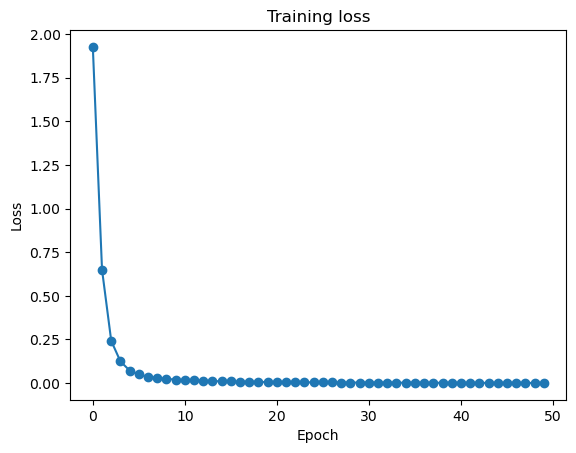

In [7]:
plt.plot(hist, marker='o'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training loss'); plt.show()

## 5. Translation using Trained Model

In [8]:
def translate_fr_number(text_fr, max_len=10):
    
    """
    text_fr : French number string, e.g. "soixante-quinze"
    returns  : English number string, e.g. "seventy five"
    """
    model.eval()                           # disable dropout, etc.

    # 1)  Tokenise + map to IDs  ------------------------------------------
    src_ids = [vocab_fr.get_stoi()[tok] for tok in fr_tok(text_fr)]
    src     = torch.tensor([src_ids])      # shape [1, src_len]

    # 2)  Begin target sequence with <bos> -------------------------------
    tgt_ids = [BOS_ID]                     # running list of generated IDs

    with torch.no_grad():                  # no gradients needed at inference
        for _ in range(max_len):
            tgt_in  = torch.tensor([tgt_ids])          # [1, cur_len]
            logits  = model(src, tgt_in)               # forward pass
            next_id = logits[:, -1].argmax(-1).item()  # greedy pick

            # stop if <eos> or <pad> predicted
            if next_id in (EOS_ID, PAD):
                break

            tgt_ids.append(next_id)

    # 3)  Convert IDs back to English words ------------------------------
    eng_tokens = [vocab_en.lookup_token(i) for i in tgt_ids[1:]]  # skip <bos>
    return " ".join(eng_tokens)


In [10]:
print(translate_fr_number("Quatre-vingt-quinze"))
num2words(90, lang='fr')

ninety


'quatre-vingt-dix'

## 6. Visualizing Attention

In [16]:
import math
def run_with_hidden(model, src, tgt):
    """Forward pass that also returns (dec_out, memory) without
       modifying the MiniTransformer class itself."""
    with torch.no_grad():
        src_emb = model.es(src) + model.pos[:src.size(1)]
        tgt_emb = model.et(tgt) + model.pos[:tgt.size(1)]
        memory  = model.tr.encoder(src_emb)      # encoder part
        dec_out = model.tr.decoder(tgt_emb, memory)
        logits  = model.fc(dec_out)
    return logits, dec_out, memory


In [17]:

src_str   = "vingt-cinq"
src_ids   = [vocab_fr.get_stoi()[tok] for tok in fr_tok(src_str)]
src = torch.tensor([src_ids])            # shape [1, src_len]

model.eval()                                    # inference mode
tgt_ids = [BOS_ID]                              # start with <bos>

with torch.no_grad():
    for _ in range(8):                          # length cap = 8
        tgt_tensor = torch.tensor([tgt_ids])    # [1, cur_len]
        logits, dec_hid, mem =  run_with_hidden(model, src, tgt_tensor)
        next_id = logits[:, -1].argmax(-1).item()         # greedy pick
        if next_id in (EOS_ID, PAD): break
        tgt_ids.append(next_id)
Q = dec_hid.squeeze(0)                          # [tgt_len, d]
K = mem.squeeze(0).transpose(0, 1)              # [d, src_len]
attn = torch.softmax(Q @ K / math.sqrt(Q.size(-1)), dim=-1)  # [tgt_len, src_len]

# Skip <bos> row for visual clarity
attn = attn[1:].cpu().numpy()                   # [tgt_len-1, src_len]

                             # start with <bos>
with torch.no_grad():
    for _ in range(8):                          # length cap = 8
        tgt_tensor = torch.tensor([tgt_ids])    # [1, cur_len]
        logits= model(src,
                                     tgt_tensor)  # decoder & enc hiddens
        next_id = logits[:, -1].argmax(-1).item()         # greedy pick
        if next_id in (EOS_ID, PAD): break
        tgt_ids.append(next_id)


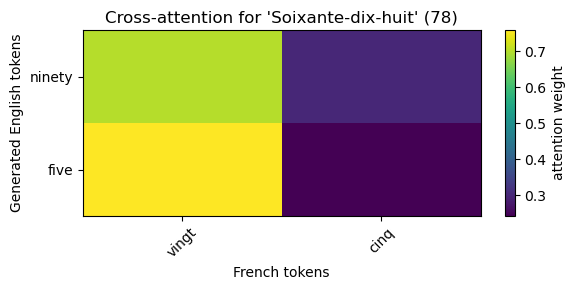

In [18]:
# 4) Plot heat-map
# ------------------------------------------------------------------
fr_tokens  = fr_tok(src_str)
en_tokens  = [vocab_en.lookup_token(i) for i in tgt_ids[1:]]  # skip <bos>

plt.figure(figsize=(6, 3))
plt.imshow(attn, aspect="auto")
plt.xticks(range(len(fr_tokens)), fr_tokens, rotation=45)
plt.yticks(range(len(en_tokens)), en_tokens)
plt.xlabel("French tokens")
plt.ylabel("Generated English tokens")
plt.title("Cross-attention for 'Soixante-dix-huit' (78)")
plt.colorbar(label="attention weight")
plt.tight_layout()
plt.show()